In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip install pyDOE

# Maziar Raissi's Baseline: Nonlinear Schrodinger

Одномерное нелинейное уравнение Шредингера:
\begin{equation*}
ih_{t}+h_{xx}+\beta|h|^{2}h=0
\end{equation*}

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time

In [ ]:
#np.random.seed(1234)
#tf.set_random_seed(1234)

In [ ]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, self.u_x , self.v_x = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        #self.optimizer_Adam = tf.train.AdamOptimizer()
        #self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        pass
        #print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        '''
        for it in range(nIter):
            if it % 100 == 0:
              print(it)
            self.sess.run(self.train_op_Adam, tf_dict)
        '''                                                                                                                 
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        u_x = self.sess.run(self.u_x, tf_dict) 
        v_x = self.sess.run(self.v_x, tf_dict) 
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, u_x, v_x, f_u_star, f_v_star

In [ ]:
import scipy.io

In [ ]:
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 100
N_b = 100
N_f = 10000
layers = [2, 100, 100, 100, 100, 2]
        
data = scipy.io.loadmat('/content/gdrive/MyDrive/PINNs/NLS.mat')
    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
    
X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]
    
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
    
X_f = lb + (ub-lb)*lhs(2, N_f)
            
#model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)

* Training:

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
             
start_time = time.time()                
model.train(500)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
        
u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

* write to file:

In [ ]:
solution = open('u_v_psi.txt','w')
grad = open('ux_vx.txt','w')
f = open('f_u_v.txt','w')
for i in range (u.shape[0]):
    solution.write(str(u[i][0])+' '+str(v[i][0])+'\n')
    grad.write(str(u_x[i][0])+' '+str(v_x[i][0])+'\n')
    f.write(str(f_u[i][0])+' '+str(f_v[i][0])+'\n')
solution.close()
grad.close()
f.close()

In [ ]:
from google.colab import files

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
solution = open('/content/gdrive/MyDrive/PINNs/u_v_psi.txt','r')
grad = open('/content/gdrive/MyDrive/PINNs/ux_vx.txt','r')
f = open('/content/gdrive/MyDrive/PINNs/f_u_v.txt','r')
u = []; v = []
u_x = []; v_x = []
f_u = []; f_v = []
for line in solution:
    split = line.split()
    u.append(float(split[0]))
    v.append(float(split[1]))
for line in grad:
    split = line.split()
    u_x.append(float(split[0]))
    v_x.append(float(split[1]))
for line in f:
    split = line.split()
    f_u.append(float(split[0]))
    f_v.append(float(split[1]))
solution.close()
grad.close()
f.close()

In [ ]:
u = np.array(u); v = np.array(v)
u_x = np.array(u_x); v_x = np.array(v_x)
f_u = np.array(f_u); f_v = np.array(f_v)

In [ ]:
u_star.shape

(51456, 1)

In [ ]:
u_exact = np.array([uu[0] for uu in u_star])
v_exact = np.array([uu[0] for uu in v_star])

* test error:

In [ ]:
h = np.sqrt(u**2 + v**2)
h_exact = np.sqrt(u_exact**2+v_exact**2)

In [ ]:
error_u = np.linalg.norm(u_exact-u,2)/np.linalg.norm(u_exact,2)
error_v = np.linalg.norm(v_exact-v,2)/np.linalg.norm(v_exact,2)
error_h = np.linalg.norm(h_exact-h,2)/np.linalg.norm(h_exact,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 1.904537e-03
Error v: 2.662363e-03
Error h: 1.211787e-03


* Остаток PDE:

In [ ]:
import numpy as np

In [ ]:
f_u = np.array(f_u)
f_v = np.array(f_v)
f = np.sqrt(f_u**2 + f_v**2)
f_norm = np.linalg.norm(f, 2)
print('%.3f'%(f_norm))

1.402


* interpolation

In [ ]:
U = griddata(X_star, u.flatten(), (X, T), method='cubic')
V = griddata(X_star, v.flatten(), (X, T), method='cubic')
H = griddata(X_star, h.flatten(), (X, T), method='cubic')
U_x = griddata(X_star, u_x.flatten(), (X, T), method='cubic')
V_x = griddata(X_star, v_x.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v.flatten(), (X, T), method='cubic')

In [ ]:
U_ex = griddata(X_star, u_exact.flatten(), (X, T), method='cubic')
V_ex = griddata(X_star, v_exact.flatten(), (X, T), method='cubic')

In [ ]:
H = griddata(X_star, h.flatten(), (X, T), method='cubic')

In [ ]:
H_exact = griddata(X_star, h_exact.flatten(), (X, T), method='cubic')

* colormap

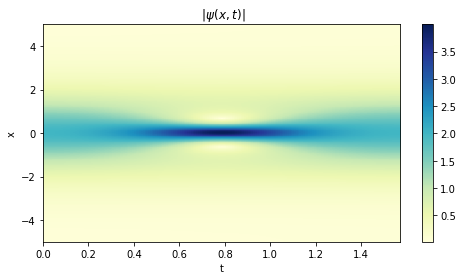

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(H.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(colormap)
plt.xlabel('t')
plt.ylabel('x')
plt.title(' $ |\psi(x,t)| $')
pass

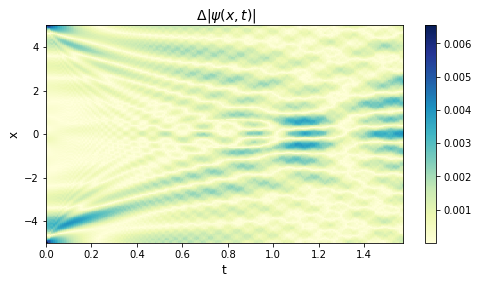

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(np.abs(H-H_exact).T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(colormap)
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title(' $ \Delta|\psi(x,t)| $', fontsize=14)
pass

* colormap остатка PDE:

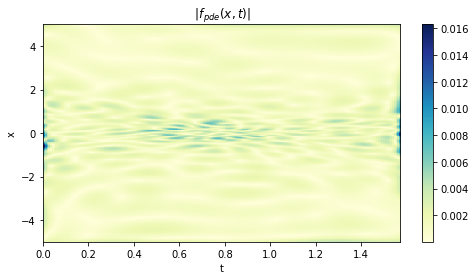

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(F_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
fig.colorbar(colormap)
plt.xlabel('t')
plt.ylabel('x')
plt.title(' $ |f_{pde}(x,t)| $')
pass

In [ ]:
print(x.shape)
print(t.shape)
print(H.shape)

(256, 1)
(201, 1)
(201, 256)


In [ ]:
print(lb)
print(ub)

[-5.  0.]
[5.         1.57079633]


* Срезы решения - солитоны НУШ:

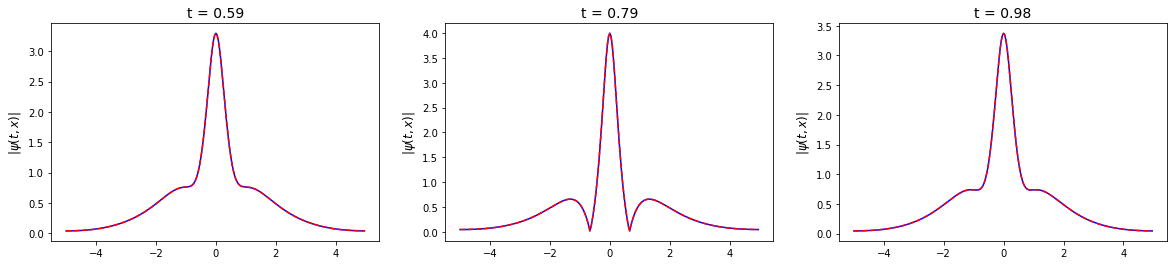

In [ ]:
i1 = int(0.59 /(1.5708/t.shape[0])) - 1
i2 = int (0.79 /(1.5708/t.shape[0])) - 1
i3 = int(0.98 /(1.5708/t.shape[0])) - 1
soliton1 = H[i1, :]
soliton2 = H[i2, :]
soliton3 = H[i3, :]
fig, ax = plt.subplots(1,3, figsize = (20,4))
ax[0].plot(x, soliton1, 'b-')
ax[0].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[0].plot(x, Exact_h[:,i1], 'r--')
ax[0].set_title('t = 0.59',fontsize = 14)
ax[1].plot(x, soliton2,'b-')
ax[1].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[1].plot(x, Exact_h[:,i2],'r--')
ax[1].set_title('t = 0.79',fontsize = 14)
ax[2].plot(x, soliton3,'b-')
ax[2].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[2].plot(x, Exact_h[:,i3],'r--')
ax[2].set_title('t = 0.98',fontsize = 14)
pass

In [ ]:
dx = (ub[0]-lb[0])/x.shape[0]
dx

0.0390625

# Интегралы уравнения

Одномерное нелинейное уравнение Шредингера:
\begin{equation*}
ih_{t}+h_{xx}+\beta|h|^{2}h=0
\end{equation*}
Интегралы этого уравнения:
* **Число квантов:**
\begin{equation*}
P = \int |h|^{2} dx
\end{equation*}

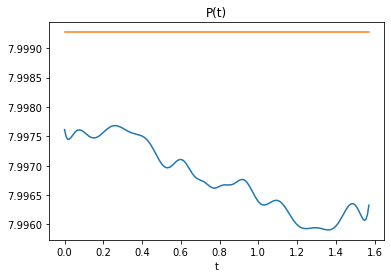

In [ ]:
H_2 = H**2
H_ex_2 = H_exact**2
P = np.array([H_2[i,:].sum() for i in range(H_2.shape[0])])
P_ex = np.array([H_ex_2[i,:].sum() for i in range(H_ex_2.shape[0])])
dx = (ub[0]-lb[0])/x.shape[0]
P *= dx
P_ex *= dx
plt.plot(t, P)
plt.plot(t, P_ex)
plt.xlabel('t')
plt.title('P(t)')
#plt.ylim([0,1.01])
pass

Относительное изменение числа квантов:

In [ ]:
dP = P.max() - P.min()
print('dP: %e' %(dP))
print('dP/P: %e'%(dP/np.abs(P).max()))

dP: 1.776479e-03
dP/P: 2.221242e-04


* **Интеграл энергии:**
\begin{equation*}
H = \int (|h_{x}|^{2} - \frac{\beta}2|h|^{4})dx
\end{equation*}

In [ ]:
U_ex.shape

(201, 256)

In [ ]:
t.shape

(201, 1)

In [ ]:
Ux_exact = np.array([[row[i]-row[i-1] for i in range(1,row.shape[0])] for row in U_ex])

In [ ]:
Vx_exact = np.array([[row[i]-row[i-1] for i in range(1,row.shape[0])] for row in V_ex])

In [ ]:
col = np.array([[u] for u in Ux_exact[:,0]])
col.shape

(201, 1)

In [ ]:
Ux_exact = np.hstack((col, Ux_exact))

In [ ]:
col = np.array([[u] for u in Vx_exact[:,0]])
Vx_exact = np.hstack((col, Vx_exact))

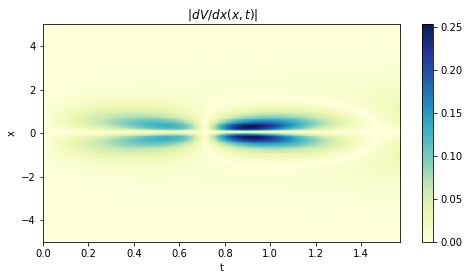

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(np.abs(Vx_exact).T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(colormap)
plt.xlabel('t')
plt.ylabel('x')
plt.title(' $ |dV/dx(x,t)| $')
pass

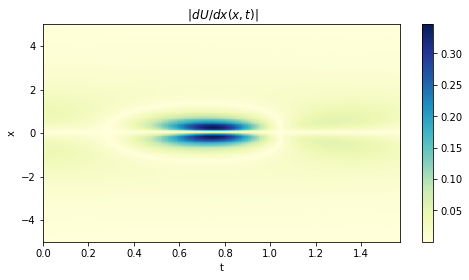

In [ ]:
Ux_exact /= dx
Vx_exact /= dx

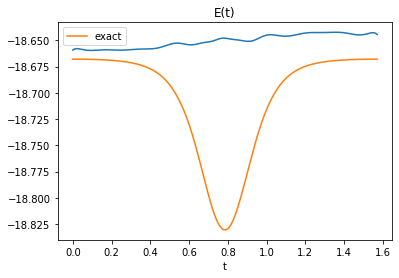

In [ ]:
Hamiltonian = U_x**2 + V_x**2 - H_2**2
Hamilton_ex = Ux_exact**2 + Vx_exact**2 - H_ex_2**2
E = np.array([Hamiltonian[i,:].sum() for i in range(Hamiltonian.shape[0])])
E_ex = np.array([Hamilton_ex[i,:].sum() for i in range(Hamilton_ex.shape[0])])
E *= dx
E_ex *= dx
plt.plot(t, E)
plt.plot(t, E_ex, label = 'exact')
plt.xlabel('t')
plt.title('E(t)')
plt.legend()
pass

In [ ]:
dE = E.max() - E.min()
print('dE: %e' %(dE))
print('dE/E: %e'%(dE/np.abs(E).max()))

dE: 1.733296e-02
dE/E: 9.289043e-04


* **Импульс:**
\begin{equation*}
I = \frac{i}{2}\int (h^{*}h_x - hh_x^{*})dx
\end{equation*}

In [ ]:
I = np.array([(V[i,:]*U_x[i,:]-U[i,:]*V_x[i,:]).sum() for i in range(U.shape[0])])
I_ex = np.array([(V_ex[i,:]*Ux_exact[i,:]-U_ex[i,:]*Vx_exact[i,:]).sum() for i in range(U_ex.shape[0])])
I *= dx
I_ex *= dx
dI = I.max() - I.min()
print('dI: %e' %(dI))
print('dI/I: %e'%(dI/np.abs(I).max()))

dI: 1.594171e-03
dI/I: 9.492585e-01


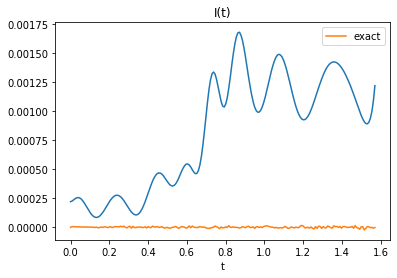

In [ ]:
plt.plot(t, I)
plt.plot(t, I_ex, label = 'exact')
plt.xlabel('t')
plt.title('I(t)')
plt.legend()
pass

По зависимости импульса от времени можно сказать,что в начальный момент времени импульс близок к нулю, и, соответственно, есть смысл рассматривать только абсолютное изменение импульса.

* Относительные изменения величин:

* число квантов:

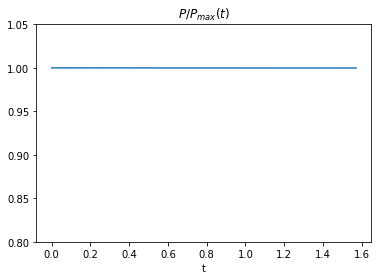

In [ ]:
plt.plot(t, P/P.max())
plt.xlabel('t')
plt.title('$ P/P_{max} (t) $')
plt.ylim([0.8,1.05])
pass

* Энергия:

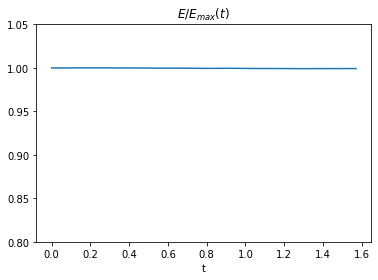

In [ ]:
plt.plot(t, np.abs(E)/np.abs(E).max())
plt.xlabel('t')
plt.title('$ E/E_{max} (t) $')
plt.ylim([0.8,1.05])
pass

* Эволюция солитона во времени

(Файл soliton.gif)

In [ ]:
for i in range(t.shape):
  fig, ax = plt.subplots(1,1,figsize = (6,4))
  ax.plot(x, H2[i,:], color='k')
  ax.set_xlabel('x')
  ax.set_ylim([-0.1,4.1])
  plt.savefig(f'sol{i}.jpg')

In [ ]:
from PIL import Image
 
# Список для хранения кадров
frames = []
 
for i in range(1, 201):
    frame = Image.open(f'sol{i}.jpg')
    frames.append(frame)
 
frames[0].save(
    'soliton.gif',
    save_all=True,
    append_images=frames[1:],
    optimize=True,
    duration=100,
    loop=0
)

# Подбор параметров архитектуры сети

# Таблица 1.
* Фиксированная функция активации: **tanh(x)**.
  \begin{array}{|c|c|c|c|c|c|c|c|c|c}\hline\\ \\
  Архитектура & dP & dP/P_{max} & dE & dE/dE_{max} & dI & dI/I_{max} & \delta u & \delta v & \delta \psi\\ \hline\\ \\
  [2, 70,70,70,70,2] & 3.8e-3 & 4.7e-4 & 3.4e-2 & 1.8e-3 & 1.9e-3 & 0.99 & 2.9e-3 & 4.3e-3 & 1.5e-3\\ \hline\\ \\
  [2, 70,70,70,70,70,2] & 1.5e-3 & 1.9e-4 & 1.3e-2 & 6.7e-4 & 1.2e-3 & 1.9 & 1.8e-3 & 2.4e-3& 1.2e-3  \\ \hline\\ \\
  [2, 70,70,70,70,70,70,2] & 3.4e-3 & 4.3e-4 & 3.3e-2 & 1.8e-3 & 1.9e-3 & 1.04 & 2.5e-3 &3.7e-3&1.5e-3   \\ \hline\\ \\
  [2,100,100,100,2] & 3.1e-3 & 3.8e-4 & 3.0e-2 & 1.6e-3 & 2.3e-3 & 0.86 & 2.6e-3 & 3.7e-3 & 1.3e-3 \\ \hline\\ \\
  \textbf{[2,100,100,100,100,2]} & \textbf{8.1e-4} & 1.e-4 & \textbf{9.5e-3} & 5.1e-4 & \textbf{9.5e-4} & 1.28 & 1.6e-3 & 2.1e-3& 1.2e-3\\ \hline\\ \\
  \textbf{[2,100, 100, 100,100,100,2]} & \textbf{7.6e-4} & 9.5e-5 & \textbf{4.8e-3} & 2.6e-4 & \textbf{1.05e-3} & 1.07 & 1.5e-3 & 1.9e-3& 1.1e-3\\ \hline\\
  \textbf{[2,100, 100, 100,100,100,100,2]} & \textbf{1.0e-3}& 1.3e-4 & \textbf{6.8e-3}& 3.7e-4 & \textbf{5.6e-4}&0.77 & 1.5e-3& 1.9e-3 & 1.2e-3\\ \hline\\
  [2,130,130,130,2] & 3.4e-3 & 4.2e-4 & 2.8e-2 & 1.5e-3 & 1.8e-3 & 1.55 & 2.9e-3 & 4.1e-3 & 1.5e-3 \\ \hline\\ \\
  [2,130,130, 130,130,2] & 1.9e-3 & 2.4e-4 & 2.1e-2 & 1.1e-3 & 1.2e-3 & 1.13 & 1.9e-3 & 2.8e-3 & 1.1e-3 \\ \hline\\ \\
  \textbf{[2,130,130, 130,130,130,2]} & \textbf{8.8e-4} & 1.1e-4 & \textbf{7.1e-3} & 3.8e-4 & \textbf{1.1e-3} & 1.17 & 1.5e-3 & 1.87e-3 & 1.12e-3 \\ \hline\\ \\
\textbf{[2,130,130, 130,130,130,130,2]} & \textbf{6.5e-4} & 8.1e-5 & \textbf{6.1e-3} & 3.3e-4 & \textbf{6.9e-4} & 1.79 & 1.55e-3 & 1.98e-3 & 1.16e-3 \\ \hline\\ \\
  \textbf{[2,130,130, 130,130,130,130,130,2]} & \textbf{9.4e-4} & 1.2e-4 & \textbf{9.0e-3} & 4.8e-4 & \textbf{1.0e-3} & 0.84 & 1.42e-3 & 1.8e-3 & 1.1e-3 \\ \hline\\ \\
  [2,150,150,150,2] & 2.3e-3 & 2.9e-4 & 1.9e-2 & 1.0e-3 & 2.5e-3 & 1.38 & 2.6e-3 & 3.8e-3 & 1.2e-3 \\ \hline\\ \\
  [2,150,150,150,150, 2] & 1.2e-3 & 1.4e-4 & 1.4e-2 & 7.3e-4 & 1.6e-3 & 0.96 & 1.5e-3 & 1.9e-3 & 1.18e-3 \\ \hline\\ \\
  \textbf{[2,150,150,150,150,150, 2]} & \textbf{1.3e-3} & 1.7e-4 & \textbf{8.6e-3} & 4.6e-4 & \textbf{7.5e-4} & 0.96 & 1.7e-3 & 2.2e-3 & 1.19e-3 \\
  \end{array}

Оптимальным из рассмотренных вариантов является структура: 5-7 слоёв с 100-130 нейронами на каждом слое.

# Таблица 2.
* Фиксированная архитектура: [2, 130, 130, 130, 2]

  \begin{array}{|c|c|c|c|c|c|c|c|c|c|c}\hline\\ \\
  name & function & dP& dP/P_{max} & dE & dE/dE_{max} & dI & dI/I_{max} & \delta u & \delta v & \delta \psi\\ \hline\\ \\
  \textbf{tanh} & \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}&\textbf{3.4e-3} & \textbf{4.2e-4} & \textbf{2.8e-2} & \textbf{1.5e-3} & \textbf{1.8e-3} & \textbf{1.55} & \textbf{2.9e-3} & \textbf{4.1e-3} & \textbf{1.5e-3} \\\hline\\ \\
  relu &  \begin{cases}
   0 &\text{x<0}\\
   1 &\text{x >= 0}
 \end{cases} & 1.38 & 0.26 & 3.54 & 0.67 & 0.28 & 0.93 & 0.8 & 1.07& 0.52  \\ \hline\\ \\
  elu & \begin{cases}
   x &\text{x>0}\\
   \alpha(e^{x}-1) &\text{x <= 0}
 \end{cases} & 1.51 & 0.24 & 5.15 & 0.56 & 6.04e-2 & 0.36 &0.93&1.24 &4.38   \\ \hline\\ \\
  sigmoid & \frac{1}{1+e^{-x}} & 6.9e-2 & 8.7e-3 & 0.62 & 3.4e-2 & 1.3e-2 & 1.09 & 4.1e-2 & 6.7e-2 & 1.1e-2 \\ \hline\\ \\
  swish & \frac{x}{1+e^{-x}} & 4.0e-2 & 5.0e-3 & 0.35 & 1.9e-2 & 7.4e-3 & 1.73 & 2.9e-2 & 4.6e-2& 7.7e-3\\ \hline\\ \\
  softmax &\frac{e^{x_{j}}}{\sum{e^{x_{i}}}} & 0.73 & 9.9e-2 & 4.08 & 0.27 & 4.5e-2 & 0.75 & 0.67 & 0.91 & 0.19\\ \hline\\
  sech & \frac{2}{e^{x}+e^{-x}} & 3.3e-2& 4.1e-3& 0.39& 2.1e-2& 9.5e-3& 1.417 & 2.4e-2 & 3.9e-2 & 6.2e-3\\
  \end{array}

Лучший результат показала baseline-активационная функция tanh(x). Из других вариантов наилучшие результаты были для swish(x) и sech(x).

# Nonlinear Schrodinger Equation with nonlinear dispersion

Одномерное нелинейное уравнение Шредингера c нелинейной дисперсией:
\begin{equation*}
ih_{t}+h_{xx}+\beta|h|^{2}h+i\alpha|h|^{2}h_x=0
\end{equation*}

In [ ]:
class NLS_Modified:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, self.u_x , self.v_x = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*(v + u_x) # отличие только в уравнении
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*(u  - v_x)   
        
        return f_u, f_v
    
    def callback(self, loss):
        pass
        #print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        for it in range(nIter):
            if it % 1000 == 0:
              print(it)
            self.sess.run(self.train_op_Adam, tf_dict)
                                                                                                                         
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        u_x = self.sess.run(self.u_x, tf_dict) 
        v_x = self.sess.run(self.v_x, tf_dict) 
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, u_x, v_x, f_u_star, f_v_star

In [ ]:
model = NLS_Modified(x0, u0, v0, tb, X_f, layers, lb, ub)
             
start_time = time.time()                
model.train(5000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
        
u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

0
1000
2000
3000
4000
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000766
  Number of iterations: 13105
  Number of functions evaluations: 14150
Training time: 2697.0345


* запись в файл:

In [ ]:
solution = open('u_v_psi-1.txt','w')
grad = open('ux_vx-1.txt','w')
f = open('f_u_v-1.txt','w')
for i in range (u.shape[0]):
    solution.write(str(u[i][0])+' '+str(v[i][0])+'\n')
    grad.write(str(u_x[i][0])+' '+str(v_x[i][0])+'\n')
    f.write(str(f_u[i][0])+' '+str(f_v[i][0])+'\n')
solution.close()
grad.close()
f.close()

In [ ]:
solution = open('u_v_psi-1.txt','r')
grad = open('ux_vx-1.txt','r')
f = open('f_u_v-1.txt','r')
u = []; v = []
ux = []; vx = []
fu = []; fv = []
for line in solution:
    split = line.split()
    u.append(float(split[0]))
    v.append(float(split[1]))
for line in grad:
    split = line.split()
    ux.append(float(split[0]))
    vx.append(float(split[1]))
for line in f:
    split = line.split()
    fu.append(float(split[0]))
    fv.append(float(split[1]))
solution.close()
grad.close()
f.close()

In [ ]:
u = np.array(u)
v = np.array(v)
ux = np.array(ux)
vx = np.array(vx)
fu = np.array(fu)
fv = np.array(fv)

In [ ]:
h = np.sqrt(u**2 + v**2)

* Остаток PDE:

In [ ]:
f = np.sqrt(fu**2 + fv**2)
            
err_pde = np.linalg.norm(f,2)
print('Error u: %.3f' % (err_pde))


Error u: 6.010


Для сравнения - норма f для решения НУШ без дисперсии: 0.354 

In [ ]:
U = griddata(X_star, u.flatten(), (X, T), method='cubic')
V = griddata(X_star, v.flatten(), (X, T), method='cubic')
H = griddata(X_star, h.flatten(), (X, T), method='cubic')
Ux = griddata(X_star, ux.flatten(), (X, T), method='cubic')
Vx = griddata(X_star, vx.flatten(), (X, T), method='cubic')

In [ ]:
Fu = griddata(X_star, f_u.flatten(), (X, T), method='cubic')
Fv = griddata(X_star, f_v.flatten(), (X, T), method='cubic')

In [ ]:
F = griddata(X_star, f.flatten(), (X, T), method='cubic')

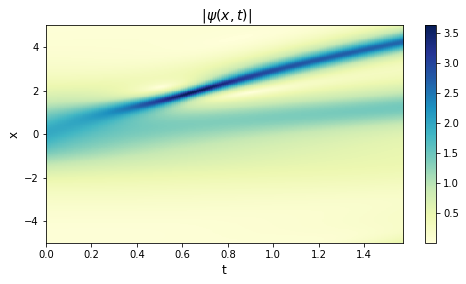

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(H.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(colormap)
plt.xlabel('t',fontsize = 12)
plt.ylabel('x',fontsize = 12)
plt.title(' $ |\psi(x,t)| $', fontsize = 14)
pass

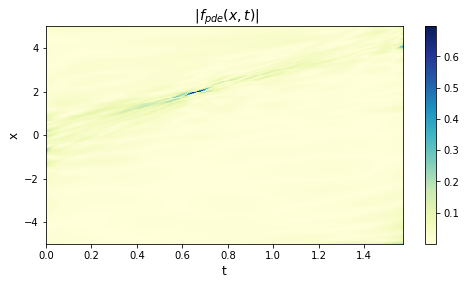

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(F.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
fig.colorbar(colormap)
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title(' $ |f_{pde}(x,t)| $', fontsize = 14)
pass

* Срез солитонов:

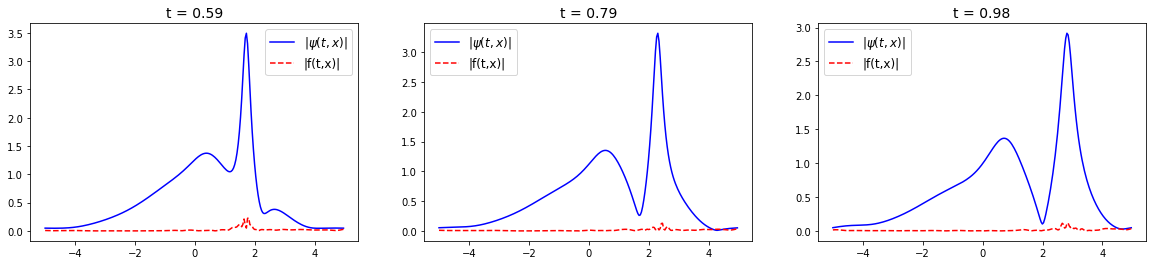

In [ ]:
i1 = int(0.59 /(1.5708/t.shape[0])) - 1
i2 = int (0.79 /(1.5708/t.shape[0])) - 1
i3 = int(0.98 /(1.5708/t.shape[0])) - 1
soliton1 = H[i1, :]
soliton2 = H[i2, :]
soliton3 = H[i3, :]
fig, ax = plt.subplots(1,3, figsize = (20,4))
ax[0].plot(x, soliton1, 'b-', label = '$|\psi(t,x)|$')
#ax[0].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[0].plot(x, F[i1,:], 'r--',label = '|f(t,x)|')
ax[0].set_title('t = 0.59',fontsize = 14)
ax[1].plot(x, soliton2,'b-', label = '$|\psi(t,x)|$')
#ax[1].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[1].plot(x, F[i2,:],'r--',label = '|f(t,x)|')
ax[1].set_title('t = 0.79',fontsize = 14)
ax[2].plot(x, soliton3,'b-',label = '$|\psi(t,x)|$')
#ax[2].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[2].plot(x, F[i3,:],'r--',label = '|f(t,x)|')
ax[2].set_title('t = 0.98',fontsize = 14)
ax[0].legend(fontsize = 12)
ax[1].legend(fontsize = 12)
ax[2].legend(fontsize = 12)
pass

# Интегралы уравнения:

* **Число квантов:**
\begin{equation*}
P = \int |h|^{2} dx
\end{equation*}

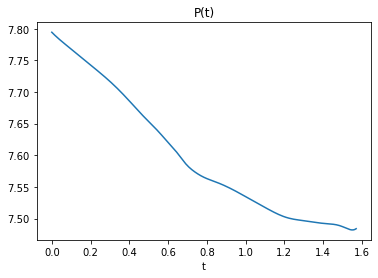

In [ ]:
H_2 = H**2
P = np.array([H_2[i,:].sum() for i in range(H_2.shape[0])])
dx = (ub[0]-lb[0])/x.shape[0]
P *= dx
plt.plot(t, P)
plt.xlabel('t')
plt.title('P(t)')
#plt.ylim([0,1.01])
pass

In [ ]:
dP = P.max() - P.min()
print('dP: %e' %(dP))
print('dI/I: %e'%(dP/np.abs(P).max()))

dP: 3.121520e-01
dI/I: 4.004855e-02


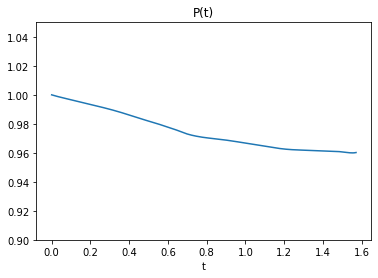

In [ ]:
plt.plot(t, P/P.max())
plt.xlabel('t')
plt.title('P(t)')
plt.ylim([0.9,1.05])
pass

* **Интеграл энергии:**
\begin{equation*}
H = \int (|h_{x}|^{2} - \frac{\beta}2|h|^{4}-\frac{i|h|^2}{4}(h^*h_x - hh_x^*))dx
\end{equation*}

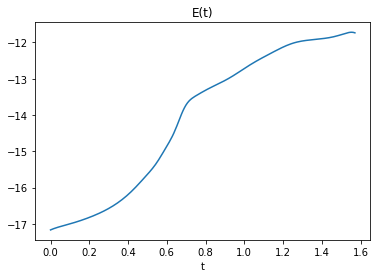

In [ ]:
Hamiltonian = Ux**2 + Vx**2 - H_2**2 + (U**2 + V**2)*(U * Vx - V * Ux)

E = np.array([Hamiltonian[i,:].sum() for i in range(Hamiltonian.shape[0])])
E *= dx
plt.plot(t, E)
plt.xlabel('t')
plt.title('E(t)')
pass

In [ ]:
dE = E.max() - E.min()
print('dE: %e' %(dE))
print('dE/E: %e'%(dE/np.abs(E).max()))

dE: 5.443698e+00
dE/E: 3.171395e-01


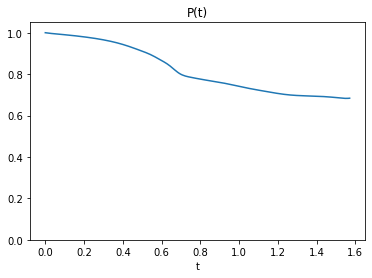

In [ ]:
plt.plot(t, np.abs(E)/np.abs(E).max())
plt.xlabel('t')
plt.title('P(t)')
plt.ylim([0.0,1.05])
pass

*  Импульс 
\begin{equation*}
I = \frac{i}{2}\int (h^{*}h_x - hh_x^{*})dx
\end{equation*}
yже не является интегралом:

dI: 3.314644e-01
dI/I: 8.937881e-01


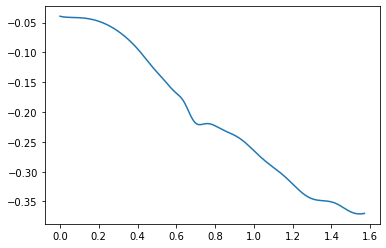

In [ ]:
I = np.array([(V[i,:]*Ux[i,:]-U[i,:]*Vx[i,:]).sum() for i in range(U.shape[0])])
I *= dx
dI = I.max() - I.min()
print('dI: %e' %(dI))
print('dI/I: %e'%(dI/np.abs(I).max()))
plt.plot(t, I)
pass

* При сравнении остатков PDE и степени изменения инвариантов видно, что для НУШ с нелинейной дисперсией точность решения ниже. Перед тем, как подбирать архитектуру для решения НУШ с дисперсией, надо определить необходимое число итераций для решения более высокой точности.

# Модифицированное уравнение Шредингера с нелинейной дисперсией

Одномерное нелинейное уравнение Шредингера c нелинейной дисперсией:
\begin{equation*}
ih_{t}+h_{xx}+\beta|h|^{2}h+i\alpha(|h|^{2}h)_x=0
\end{equation*}

In [ ]:
class NLS_Dispersion:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, self.u_x , self.v_x = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred))
        
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1e-9})#1.0 * np.finfo(float).eps})
        '''
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v + u_x*(3*u**2+v**2)+2*u*v*v_x # отличие только в уравнении
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u + v_x*(3*v**2+u**2)+2*u*v*u_x    
        
        return f_u, f_v
    
    def callback(self, loss):
        pass
        #print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        for it in range(nIter):
            if it % 1000 == 0:
              print(it)
            self.sess.run(self.train_op_Adam, tf_dict)
                                                                                                                       
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                  
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        u_x = self.sess.run(self.u_x, tf_dict) 
        v_x = self.sess.run(self.v_x, tf_dict) 
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, u_x, v_x, f_u_star, f_v_star

In [ ]:
print(u0)

нулевые ГУ:

In [ ]:
model = NLS_Dispersion(x0, u0, v0, tb, X_f, layers, lb, ub)
             
start_time = time.time()           
model.train(50000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
        
u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
Training time: 5011.0974


In [ ]:
u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

In [ ]:
f = np.sqrt(f_u**2+f_v**2)

In [ ]:
h = np.sqrt(u**2+v**2)

In [ ]:
#f = np.sqrt(f_u**2 + f_v**2)
            
err_pde = np.linalg.norm(f,2)
print('Error u: %.3f' % (err_pde))


Error u: 20.483


In [ ]:
U = griddata(X_star, u.flatten(), (X, T), method='cubic')
V = griddata(X_star, v.flatten(), (X, T), method='cubic')

In [ ]:
H = griddata(X_star, h.flatten(), (X, T), method='cubic')
Ux = griddata(X_star, u_x.flatten(), (X, T), method='cubic')
Vx = griddata(X_star, v_x.flatten(), (X, T), method='cubic')

In [ ]:
F = griddata(X_star, f.flatten(), (X, T), method='cubic')

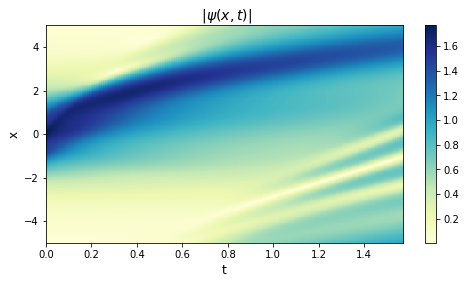

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(H.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(colormap)
plt.xlabel('t',fontsize = 12)
plt.ylabel('x',fontsize = 12)
plt.title(' $ |\psi(x,t)| $', fontsize = 14)
pass

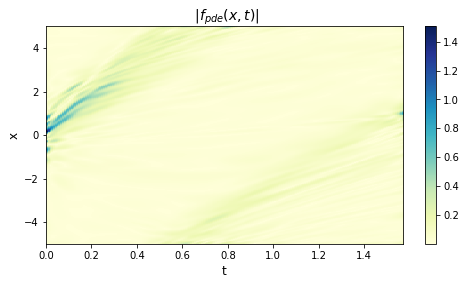

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
colormap = ax.imshow(F.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(colormap)
plt.xlabel('t',fontsize = 12)
plt.ylabel('x',fontsize = 12)
plt.title(' $ |f_{pde}(x,t)| $', fontsize = 14)
pass

* Для модифицированного НУШ ошибка получилась ещё больше. Возможно, стоит применять LBFGS optimizer в дополнение в adam, и сравнить с решением, полученным классическими методами.